<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/ShapleyComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the second dataset

In [39]:

#@title
import numpy as np
import torch 
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

!pip install flashtorch
from flashtorch.saliency import Backprop

!pip install shap 
import shap

!pip install pytorch-gradcam
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/cam.py -P local_modules -nc
!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/utils/visualize.py -P local_modules -nc
import sys
sys.path.append('local_modules')
from PIL import Image
from local_modules.visualize import visualize
import local_modules.cam as smooth

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/HierarchicalShapley.py -P local_modules -nc
import local_modules.HierarchicalShapley as HS

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/utils.py -P local_modules -nc
import local_modules.utils as utils

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/interpret11.py -P local_modules -nc
import local_modules.interpret11 as intp

torch.manual_seed(0)
dtype = torch.float

FIGSIZE = (5,4)

import torch.nn as nn
import torch.nn.functional as F

class HD_Net(nn.Module):
    def __init__(self):
        super(HD_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride=5)
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv1 = nn.Conv2d(6, 10, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 16, 4)
        self.pool2 = nn.MaxPool2d(5)
        self.fc1 = nn.Linear(16 * 9 * 11, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = self.pool0(x)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, self.num_flat_features(x))  # 16*9*11
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = HD_Net()
# Loading the trained dictionnary state

net.load_state_dict(torch.load('drive/My Drive/Interpretability/modelHD.pth')) 

data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/HD/data2/data.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

Batch_Size = 64
MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

transf = transforms.Compose( [ToTensor(), Normalize(mean=MEAN, std=STD)])

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = Batch_Size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)

# For SHAP
X,Y = next(train_loader)
bg_choice = None # Default: entire training set, "average", "white", "black" 
# Median would result in white 
background = X
if (bg_choice == "black"): 
  background = -torch.ones(X.shape)
elif (bg_choice == "white"): 
  background = torch.ones(X.shape)
elif (bg_choice == "average"): 
  avg = torch.mean(X, dim = 0)
  display_image(avg, 0)

e = shap.GradientExplainer(net, background)

# For Hierarchical 
white_bg = torch.ones(X.shape[1:])
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


class HierarchicalShap:
    """
    Explains the salient regions of images according a given network.
    """

    def __init__(self, model, background, mean=np.array([0.5, 0.5, 0.5]), sd=np.array([0.5, 0.5, 0.5])):
        """
        Parameters
        ----------
        model : the model from which you wish to study the decision
        background : used to remove the contribution of non-considered regions when constructing subsets
        mean : the mean used for image normalization (useful for plotting from input)
        sd : the standard deviation used for normalization (useful for plotting from input)
        """
        self.model = model
        self.background = background
        self.mean = mean
        self.sd = sd

    def display_cropped_images(self, images, scores):
        """
        Draw the subsets.
        Parameters
        ----------
        images : all the subsets to draw
        scores : the output score for a class 1
        """
        fig, axs = plt.subplots(4, 4, figsize=(15, 15))
        for i in range(4):
            for j in range(4):
                im = images[4 * i + j].numpy().transpose(1, 2, 0)
                im = im * self.sd + self.mean
                axs[i, j].imshow(im)
                axs[i, j].set_title("#%d score:%f " % (4 * i + j, scores[4 * i + j]))

    def construct_subsets(self, im, s=(0, 0), region_size=(None, None)):
        """
        Construct the subsets of im: all possible image resulting from removing from im the content of 0, 1, 2, 3
        or all 4 quadrants of the region defined by start and region_size .
        Parameters
        ----------
        im : the image from which to extract subsets
        s : the top left pixel coordinates of the region analyzed, a tuple of
        region_size : the size of the region analyzed
        Returns
        --------
        subsets : the list of 16 images
        r_coord : a 2x2 array where each entry is a tuple of tuples; the first indicating the start
                  of the region and the second its size
        """

        m = (s[0] + region_size[0] // 2, s[1] + region_size[1] // 2)
        e = (s[0] + region_size[0], s[1] + region_size[1])

        top_left = (s, (m[0] - s[0], m[1] - s[1]))
        top_right = ((s[0], m[1]), (m[0] - s[0], e[1] - m[1]))
        bottom_left = ((m[0], s[1]), (e[0] - m[0], m[1] - s[1]))
        bottom_right = (m, (e[0] - m[0], e[1] - m[1]))
        r_coord = np.array([[top_left, top_right], [bottom_left, bottom_right]])

        subsets_size = [16, im.shape[0], im.shape[1], im.shape[2]]

        bg = self.background
        # removing 0 features
        im1234 = bg.clone()
        im1234[:, s[0]:e[0], s[1]:e[1]] = im[:, s[0]:e[0], s[1]:e[1]]
        # removing 1 feature
        im234 = im1234.clone()
        im234[:, s[0]:m[0], s[1]:m[1]] = bg[:, s[0]:m[0], s[1]:m[1]]
        im134 = im1234.clone()
        im134[:, s[0]:m[0], m[1]:e[1]] = bg[:, s[0]:m[0], m[1]:e[1]]
        im124 = im1234.clone()
        im124[:, m[0]:e[0], s[1]:m[1]] = bg[:, m[0]:e[0], s[1]:m[1]]
        im123 = im1234.clone()
        im123[:, m[0]:e[0], m[1]:e[1]] = bg[:, m[0]:e[0], m[1]:e[1]]
        # removing 2 features
        im34 = im234.clone()
        im34[:, s[0]:m[0], m[1]:e[1]] = bg[:, s[0]:m[0], m[1]:e[1]]
        im24 = im234.clone()
        im24[:, m[0]:e[0], s[1]:m[1]] = bg[:, m[0]:e[0], s[1]:m[1]]
        im23 = im234.clone()
        im23[:, m[0]:e[0], m[1]:e[1]] = bg[:, m[0]:e[0], m[1]:e[1]]
        im14 = im134.clone()
        im14[:, m[0]:e[0], s[1]:m[1]] = bg[:, m[0]:e[0], s[1]:m[1]]
        im13 = im134.clone()
        im13[:, m[0]:e[0], m[1]:e[1]] = bg[:, m[0]:e[0], m[1]:e[1]]
        im12 = im123.clone()
        im12[:, m[0]:e[0], s[1]:m[1]] = bg[:, m[0]:e[0], s[1]:m[1]]
        # removing 3 features
        im4 = im34.clone()
        im4[:, m[0]:e[0], s[1]:m[1]] = bg[:, m[0]:e[0], s[1]:m[1]]
        im3 = im34.clone()
        im3[:, m[0]:e[0], m[1]:e[1]] = bg[:, m[0]:e[0], m[1]:e[1]]
        im2 = im24.clone()
        im2[:, m[0]:e[0], m[1]:e[1]] = bg[:, m[0]:e[0], m[1]:e[1]]
        im1 = im14.clone()
        im1[:, m[0]:e[0], m[1]:e[1]] = bg[:, m[0]:e[0], m[1]:e[1]]
        # removing 4
        im_ = bg.clone()

        subsets = torch.zeros(size=subsets_size)
        subsets[0] = im1234
        subsets[1] = im234
        subsets[2] = im134
        subsets[3] = im124
        subsets[4] = im123
        subsets[5] = im34
        subsets[6] = im24
        subsets[7] = im23
        subsets[8] = im14
        subsets[9] = im13
        subsets[10] = im12
        subsets[11] = im4
        subsets[12] = im3
        subsets[13] = im2
        subsets[14] = im1
        subsets[15] = im_

        return subsets, r_coord

    def subset_scores(self, sub, label):
        """
        Compute the scores of each subset input.
        Parameters
        ----------
        sub : the subsets of inputs
        label : the class label - typically 1 -  in which we're interested.
        Returns
        --------
        score : an array of the 16 scores for each input
        """
        outputs = self.model(sub)

        score = np.zeros(16)
        score[0] = outputs[0, label]
        score[1] = outputs[1, label]
        score[2] = outputs[2, label]
        score[3] = outputs[3, label]
        score[4] = outputs[4, label]
        score[5] = outputs[5, label]
        score[6] = outputs[6, label]
        score[7] = outputs[7, label]
        score[8] = outputs[8, label]
        score[9] = outputs[9, label]
        score[10] = outputs[10, label]
        score[11] = outputs[11, label]
        score[12] = outputs[12, label]
        score[13] = outputs[13, label]
        score[14] = outputs[14, label]
        score[15] = outputs[15, label]
        return score

    def shapley_of_quadrants(self, score):
        """
        Return a 2x2 array which contains the Shapley values associated with each quadrant
        Parameters
        ----------
        score : the network evaluation for each subset
        Returns
        --------
        shapley_coefficients : an array of the 16 scores for each input
        """

        phi1 = (score[14] - score[15] + score[0] - score[1]) / 4 \
               + (score[8] - score[11] + score[9] - score[12] + score[10] - score[13]
                  + score[2] - score[5] + score[3] - score[6] + score[4] - score[7]) / 12

        phi2 = (score[13] - score[15] + score[0] - score[2]) / 4 \
               + (score[6] - score[11] + score[7] - score[12] + score[10] - score[14]
                  + score[1] - score[5] + score[3] - score[8] + score[4] - score[9]) / 12

        phi3 = (score[12] - score[15] + score[0] - score[3]) / 4 \
               + (score[5] - score[11] + score[9] - score[14] + score[7] - score[13]
                  + score[2] - score[8] + score[1] - score[6] + score[4] - score[10]) / 12

        phi4 = (score[11] - score[15] + score[0] - score[4]) / 4 \
               + (score[8] - score[14] + score[5] - score[12] + score[6] - score[13]
                  + score[1] - score[7] + score[3] - score[10] + score[2] - score[9]) / 12

        shapley_coefficients = np.array([[phi1, phi2], [phi3, phi4]])
        return shapley_coefficients

    def get_salient_regions(self, shapley_values, tol, regions):
        """
        Determine which of the 4 quadrants are salient, i.e. have Shapley value larger than tol
        Parameters
        ----------
        shapley_values : the Shapley coefficients associated with each quadrant
        tol : the specified tolerance for a sub-region to be considered salient
        regions : the coordinates associated with each quadrant
        Returns
        --------
        srs : a list of the coordinates of the quadrants whose Shapley values were large enough
        """
        srs = []
        for i in range(len(shapley_values)):
            for j in range(len(shapley_values[0])):
                if shapley_values[i, j] > tol:
                    srs.append(regions[i, j])
        return srs

    def display_salient(self, im, srs_coll, count, filename ):
        """
        Determine which of the 4 quadrants are salient, i.e. have Shapley value larger than tol
        Parameters
        ----------
        im : the original image, in input format
        srs_coll : a collection of all regions deemed salient
        count : a normalizing mask which determines how many time each pixel was given a chance to be salient
        filename : name of the file to save the figure to
        """
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(45, 30))
        sample_image = im.numpy().transpose(1, 2, 0)
        count = count.transpose(1, 2, 0)
        image = sample_image * self.sd + self.mean
        ax1.imshow(image)
        ax2.imshow(image)
        mask = np.zeros(image.shape)

        # Count how many time each pixel was found to be in a salient region
        for srs in srs_coll:
            for sr in srs:
                start = sr[0]
                q_size = sr[1]

                xs = [start[1], start[1] + q_size[1], start[1] + q_size[1], start[1]]
                ys = [start[0], start[0], start[0] + q_size[0], start[0] + q_size[0]]
                ax2.fill(xs, ys, 'r', alpha=1 / len(srs_coll))
                mask[start[0]:start[0] + q_size[0], start[1]:start[1] + q_size[1], :] += np.ones(
                    (q_size[0], q_size[1], 3))

        # Normalize the mask by the number of tries in each region
        mask /= count
        # Normalize the mask to the range (0,1)
        mask /= np.max(mask)
        # Set to 0 elements smaller than 1/5
        negligible = (mask < 0.2)
        mask[negligible] = 0

        ax1.set_xlim([0, im.shape[2]])
        ax1.set_ylim([im.shape[1], 0])
        ax2.set_xlim([0, im.shape[2]])
        ax2.set_ylim([im.shape[1], 0])
        ax3.imshow(image * mask)
        if filename != None:
            plt.savefig(filename, dpi=300)
        return mask 

    def do_all(self, im, label, start, region_size, tol, debug=False):
        """
        Secondary main loop: do everything for one region of the image.
        ----------
        im : the input image
        start : the starting coordinates of the region
        region_size : self-explanatory
        tol : the specified tolerance for a sub-region to be considered salient
        debug : if True, all subsets, there associated scores and the Shapley values will be displayed
        Returns
        --------
        srs : a list of the coordinates of the quadrants whose Shapley values were large enough
        """
        images_final, regions = self.construct_subsets(im, start, region_size)
        score = self.subset_scores(images_final, label)
        sm = self.shapley_of_quadrants(score)
        if debug:
            self.display_cropped_images(images_final, score)
            f = plt.figure()
            sns.heatmap(sm)
            f.suptitle("Shap values of each quadrant")

        srs = self.get_salient_regions(sm, tol, regions)

        return srs

    def saliency_map(self, image, label, tolerance, only_one_run=False, debug=False, max_depth=30, filename=None):
        """
        Create and then show a saliency map built with the Hierarchical Shapley method.
        ----------
        im : the input image
        label : the label with respect to which we want to analyze - typically 1
        tolerance : the specified tolerance for a sub-region to be considered salient. A list is expected.
        only_one_run : when False, several runs are done by also considering 16 cropped versions of the input
        debug : if True, all subsets, there associated scores and the Shapley values will be displayed
        max_depth : the maximum number of divisions you want to allow before deciding the tolerance is too low.
        filename : name of the file to save the figure to
        """
        ls = []
        count = np.zeros(image.shape)
        xf = [image.shape[1], image.shape[2]]

        if only_one_run:
            starts = [(0, 0)]
            ends = [(xf[0], xf[1])]
        else:
            delta = [image.shape[1] // 20, image.shape[2] // 24]
            starts = [(0, 0), (0, delta[1]), (delta[0], 0), (delta[0], delta[1])]
            ends = [(xf[0], xf[1]), (xf[0], xf[1] - delta[1]), (xf[0] - delta[0], xf[1]),
                    (xf[0] - delta[0], xf[1] - delta[1])]

        for start in starts:
            for end in ends:
                size = (end[0] - start[0], end[1] - start[1])
                count[:, start[0]:end[0], start[1]:end[1]] += np.ones((3, size[0], size[1]))

        for tol in tolerance:
            try:
                for start in starts:
                    for end in ends:

                        size = (end[0] - start[0], end[1] - start[1])
                        srs = [(start, size)]
                        finished = []
                        k = 0
                        while len(srs) > 0:
                            if k > max_depth:
                                raise RuntimeError("Depth %d reached at tolerance %f" % (k, tol))
                            all_ = []
                            for sr in srs:
                                s = self.do_all(image, label, sr[0], sr[1], tol, debug)
                                if s == []:
                                    finished.append(((sr[0]), (sr[1])))
                                else:
                                    all_ += s
                            srs = all_
                            k += 1
                        ls.append(finished)
            except RuntimeError as w:
                print(w, "Run ignored, consider increasing tolerance.")

        return self.display_salient(image, ls, count, filename)

h = HS.HierarchicalShap(net, background = white_bg)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/cam.py’ already there; not retrieving.

File ‘local_modules/visualize.py’ already there; not retrieving.

File ‘local_modules/HierarchicalShapley.py’ already there; not retrieving.

File ‘local_modules/utils.py’ already there; not retrieving.

File ‘local_modules/interpret11.py’ already there; not retrieving.



In [0]:
train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = 1, shuffle = False, num_workers = 0)
train_loader = iter(dataloader)

# For SHAP
#for i in range(10001): 
 # print(X.shape)
 # X,Y = next(train_loader)
 # y = int(Y)
 # if y > 4998: 
 #   print(Y)
 # i += 1

In [0]:
ImF = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/dataHD", transform = transf)
batch_Size = 5
exloader = DataLoader(ImF, batch_size = batch_Size, shuffle = False, num_workers = 0)

exIter = iter(exloader)
images, labels = next(exIter)

def shap_exp(e, inp, img):
    shapley_values, indexes = e.shap_values(inp, ranked_outputs=2, nsamples=125)
    shapley_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shapley_values ]

    shap_red = [shapley_values[0][:, :, :, 0], shapley_values[1][:, :, :, 0]]
    shap_green = [shapley_values[0][:, :, :, 1], shapley_values[1][:, :, :, 1]]
    shap_blue = [shapley_values[0][:, :, :, 2], shapley_values[1][:, :, :, 2]]

    image = img[np.newaxis, :]

    shap.image_plot(shapley_values, image, indexes.numpy(), show=False)
    plt.suptitle("All channels together");
    plt.savefig('fig1.png', dpi = 300)

  

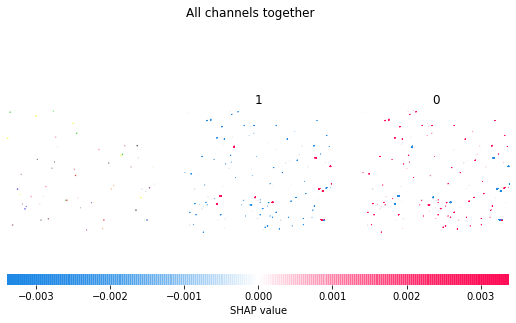

In [42]:
i = 1

image = images[i]
label = labels[i]
input_ = image.view(-1, 3, 1000, 1200) # This shape is necessary for the network 
output = net(input_)
_, predicted = torch.max(output.data, 1)

img = utils.input2image(image, MEAN, STD)

shap_exp(e, input_.detach(), img)


TypeError: ignored

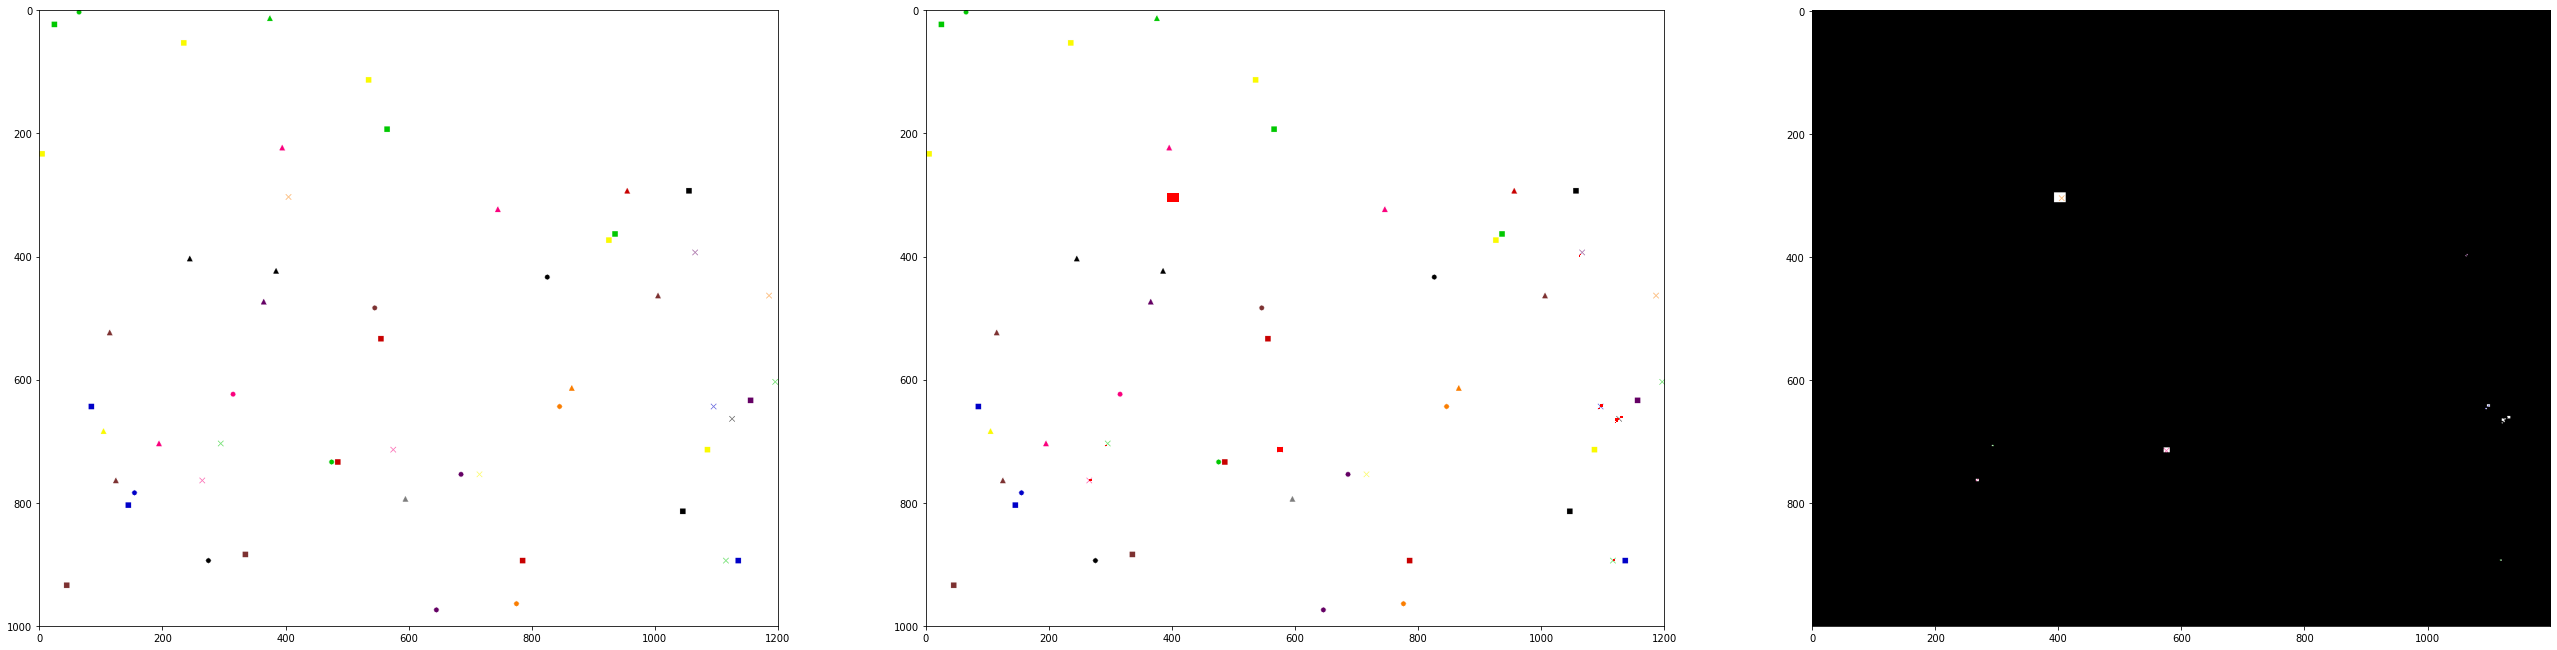

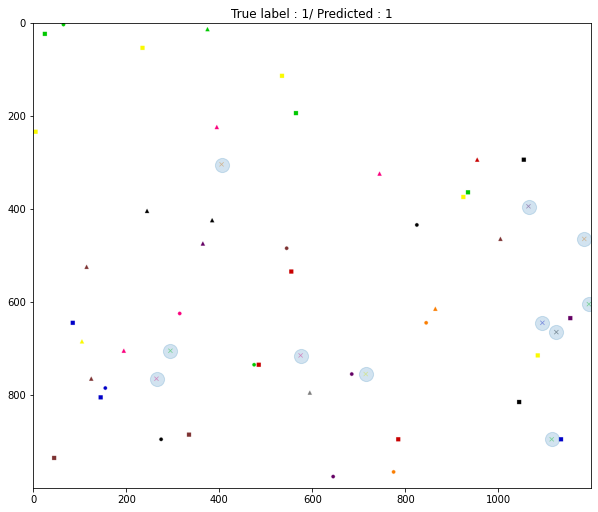

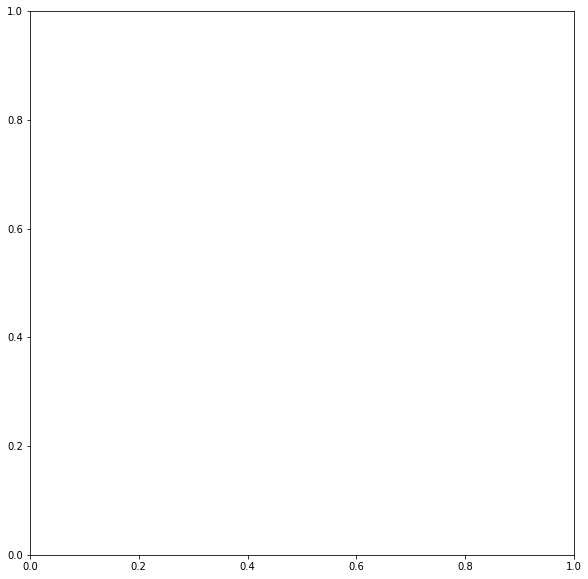

In [43]:
mask = h.saliency_map(image, label, tolerance = [12], only_one_run = True, debug=False, max_depth = 30)
import pandas as pd
positions = pd.read_csv("/content/drive/My Drive/Interpretability/img4saliencymap/dataHD/1/positions/positions_179.csv", header = None).values
utils.display_image(img, label.numpy(), int(predicted), figure_size =(10,10))
plt.scatter(positions[:,0], positions[:,1], s=200, alpha = 0.2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mask)




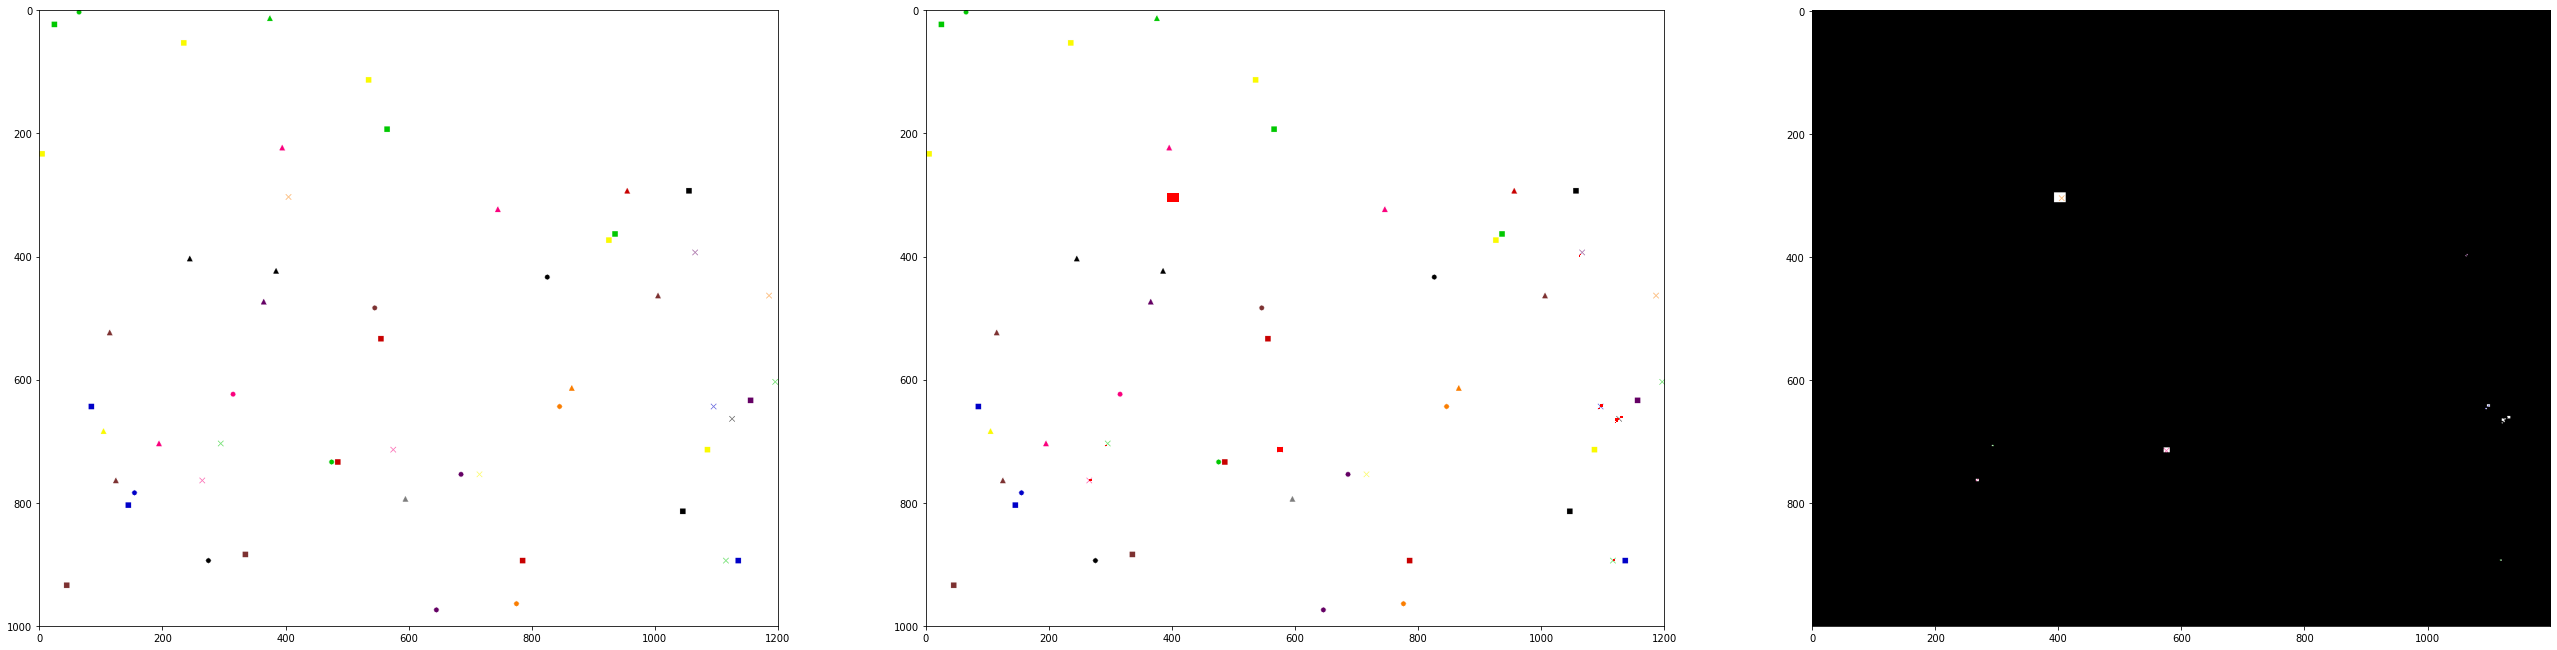

In [44]:
h2 = HierarchicalShap(net, background = white_bg)
mask2  = h2.saliency_map(image, label, tolerance = [12], only_one_run = True, debug=False, max_depth = 30)

In [45]:
print(type(mask), type(mask2))

<class 'NoneType'> <class 'numpy.ndarray'>


In [0]:
import cv2
img = (255*mask).astype(np.uint8)
blurred = cv2.blur(img,(5,5))
gray_image = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray_image,0,255,0)
f, ax = plt.subplots(figsize = (15,15))
plt.imshow(thresh, cmap = 'gray')
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


In [0]:
f, axs = plt.subplots(1,3, figsize = (24,8))
axs[0].imshow(cv2.drawContours(np.zeros(img.shape), contours, -1, (255,0,0), 3))
axs[1].plot(positions[:,0], 1000-positions[:,1],'*')
axs[1].set_ylim([0,1000])
axs[1].set_xlim([0,1200])
axs[2].imshow(cv2.drawContours(np.zeros(img.shape), contours, -1, (0,255,0), 3))
axs[2].plot(positions[:,0], positions[:,1], '*')



In [0]:
display_all_combinations = False

if display_all_combinations: 
  for contour in contours: 
    for p in positions: 
      f, axs = plt.subplots(1,1, figsize = (10,10))
      axs.imshow(cv2.drawContours(np.zeros(img.shape), contour, -1, (255,0,0), 3))
      axs.scatter(p[0], p[1], s = 20)
      r = cv2.pointPolygonTest(contour, (p[0], p[1]), False)
      axs.set_title("result %f" %r) 

In [0]:
for contour in contours: 
  f, axs = plt.subplots(1,1, figsize = (10,10))
  axs.imshow(cv2.drawContours(np.zeros(img.shape), contour, -1, (255,0,0), 3))
  axs.scatter(positions[0][0], positions[0][1], s = 20)
  r = cv2.pointPolygonTest(contour, (positions[0][0], positions[0][1]), False)
  axs.set_title("result %f" %r) 

In [0]:
positions_pred = []
for c in contours:
   M = cv2.moments(c)
   if M["m00"] != 0:
     cX = int(M["m10"] / M["m00"])
     cY = int(M["m01"] / M["m00"])
   else:
     cX, cY = 0, 0
   positions_pred.append([cX, cY])
positions_pred = np.array(positions_pred)

In [0]:
def judge_predictions_contours(positions, contours): 
  is_within = np.zeros((len(positions), len(contours)))
  for i in range(len(positions)): 
    for j in range(len(contours)): 
      is_within[i,j] = (cv2.pointPolygonTest(contours[j], (positions[i][0], positions[i][1]), False) >= 0)
  n_pred_per_point = np.sum(is_within, axis = 1) # How many times each real point was detected
  n_correct_predictions = (n_pred_per_point ==1).sum()
  multiple_pred = (n_pred_per_point > 1).sum()
  not_detected = (n_pred_per_point == 0).sum()
  invented_salient = (np.sum(is_within, axis = 0) ==0).sum()
  print(is_within)
  print("Prediction accuracy: %.2f" %(100*n_correct_predictions/len(positions)))
  print("%d detected correctly, %d not detected, %d detected more than once and %d not actually salient" %(n_correct_predictions, not_detected, multiple_pred, invented_salient))

def judge_predictions_centroids(positions, predictions): 
  distances = np.zeros((len(positions), len(predictions)))
  for i in range(len(positions)): 
    for j in range(len(predictions)): 
      d2 = (positions[i,0]-predictions[j,0])**2 + (positions[i,1]-predictions[j,1])**2
      distances[i,j] = (d2 < 150)
  n_pred_per_point = np.sum(distances, axis = 1) # How many times each real point was detected
  n_correct_predictions = (n_pred_per_point ==1).sum()
  multiple_pred = (n_pred_per_point > 1).sum()
  not_detected = (n_pred_per_point == 0).sum()
  invented_salient = (np.sum(distances, axis = 0) ==0).sum()
  print(distances)
  print("Prediction accuracy: %.2f" %(100*n_correct_predictions/len(positions)))
  print("%d detected correctly, %d not detected, %d detected more than once and %d not actually salient" %(n_correct_predictions, not_detected, multiple_pred, invented_salient))

judge_predictions_contours(positions, contours)



judge_predictions_centroids(positions, positions_pred)